In [178]:
import os
import glob

# Afficher le répertoire courant
#print(os.getcwd())

# Mettre dossier de base
os.chdir("..\Données")

print(os.getcwd())  # Vérifie


c:\Users\nguye\Desktop\Enzo\Cours\M1 MIASHS\TER - Redshift\Données


Objectif
--------
Créer un modèle de régression linéaire (baseline OLS + Ridge) pour prédire le redshift ZSPEC
à partir des magnitudes (u, g, r, i, z, y, …). Le code :
1) charge ton .npz,
2) extrait les colonnes utiles,
3) gère les valeurs manquantes (-99, etc.),
4) crée des couleurs (différences de magnitudes),
5) split train/test, standardise,
6) entraîne OLS et Ridge,
7) évalue (MAE, RMSE, R²) et trace Vrai vs Prédit.

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

0) Paramètres / fichier


In [180]:
fichiers_npz = glob.glob('*.npz')
print(f"📂 Fichiers .npz trouvés ({len(fichiers_npz)}):")
for i, fichier in enumerate(fichiers_npz):
    print(f"  {i+1}. {fichier}")

# Filtrer les fichiers contenant "COSMOS"
cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]
print(f"Fichiers COSMOS ({len(cosmos_files)}):")
for i, fichier in enumerate(cosmos_files):
    print(f"  {i+1}. {fichier}")

# Charger les données des fichiers COSMOS
data_list = []
for fichier in cosmos_files:
    try:
        data = np.load(fichier, allow_pickle=True)
        data_list.append(data)
        print(f"✅ Chargé: {fichier}")
    except Exception as e:
        print(f"❌ Erreur en chargeant {fichier}: {e}")
        print(f"Total de fichiers COSMOS chargés: {len(data_list)}")

# Vérifier les clés des données chargées
for i, data in enumerate(data_list):
    print(f"\nClés dans le fichier {cosmos_files[i]}:")
    for key in data.keys():
        print(f"  - {key}")
        # Exemple d'accès aux données
        print(f"    Shape de {key}: {data[key].shape}")


bands_all = ["u","g","r","i","z","y","J","H"]  # ordre logique des bandes
info = data['info']
print(data.files)
print(info.dtype.names)

📂 Fichiers .npz trouvés (8):
  1. COSMOS_v11_uijk_0001_photo_D.npz
  2. COSMOS_v11_uijk_0020_spec_D.npz
  3. COSMOS_v11_uijk_0073_spec_UD.npz
  4. COSMOS_v11_uijk_0213_photo_UD.npz
  5. XMM_LSS_v11_uijk_0006_spec_D.npz
  6. XMM_LSS_v11_uijk_0162_phot_D.npz
  7. XMM_LSS_v11_uijk_0162_phot_UD.npz
  8. XMM_LSS_v11_uijk_0177_spec_UD.npz
Fichiers COSMOS (4):
  1. COSMOS_v11_uijk_0001_photo_D.npz
  2. COSMOS_v11_uijk_0020_spec_D.npz
  3. COSMOS_v11_uijk_0073_spec_UD.npz
  4. COSMOS_v11_uijk_0213_photo_UD.npz
✅ Chargé: COSMOS_v11_uijk_0001_photo_D.npz
✅ Chargé: COSMOS_v11_uijk_0020_spec_D.npz
✅ Chargé: COSMOS_v11_uijk_0073_spec_UD.npz
✅ Chargé: COSMOS_v11_uijk_0213_photo_UD.npz

Clés dans le fichier COSMOS_v11_uijk_0001_photo_D.npz:
  - cube
    Shape de cube: (12054, 64, 64, 9)
  - info
    Shape de info: (12054,)
  - flag
    Shape de flag: (12054, 9)

Clés dans le fichier COSMOS_v11_uijk_0020_spec_D.npz:
  - cube
    Shape de cube: (15, 64, 64, 9)
  - info
    Shape de info: (15,)
  - flag

1) Charger les données

In [181]:
# Vérifier quelles bandes et la cible existent réellement
mag_cols = [b for b in bands_all if b in info.dtype.names]
target_col = "ZSPEC"
if target_col not in info.dtype.names:
    print("La cible ZSPEC n'est pas présente dans info. \nOn prend donc ZPHOT")
    target_col = "ZPHOT"

La cible ZSPEC n'est pas présente dans info. 
On prend donc ZPHOT


2) Construire un DataFrame

In [182]:
df = pd.DataFrame({c: info[c].astype(float) for c in mag_cols})
df["ZSPEC"] = info[target_col].astype(float)

3) Créer des couleurs

In [183]:
# Les couleurs (différences) capturent mieux la forme du SED que les magnitudes absolues.
ordered = [b for b in bands_all if b in df.columns]
for a, b in zip(ordered, ordered[1:]):
    df[f"{a}-{b}"] = df[a] - df[b]

4) Features / Cible

In [184]:
X_cols = [c for c in df.columns if c != "ZSPEC"]
X = df[X_cols].values
y = df["ZSPEC"].values

# Imputation des NaN restants (médiane par colonne)
X = SimpleImputer(strategy="median").fit_transform(X)

5) Split + standardisation

In [185]:
# Jeu minuscule -> test_size un peu plus grand pour garder au moins 2 points de test
test_size = 0.25 if len(df) >= 8 else 0.33 if len(df) >= 3 else 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

6) Modèles : OLS + Ridge

In [186]:
ols = LinearRegression().fit(X_train_s, y_train) # OLS = Ordinary Least Squares = régression linéaire classique
ridge = Ridge(alpha=1.0, random_state=42).fit(X_train_s, y_train) # Ridge = régression linéaire avec régularisation L2

def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred) # Mean Absolute Error = Erreur Absolue Moyenne
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Root Mean Squared Error = Erreur Quadratique Moyenne
    r2   = r2_score(y_true, y_pred) # Coefficient de détermination R^2 = proportion de variance expliquée
    print(f"{name:>8s} | MAE={mae:.4f} | RMSE={rmse:.4f} | R^2={r2:.4f}")
    return mae, rmse, r2

print("Colonnes magnitudes conservées:", df.columns.tolist())
print("Features utilisées:", X_cols)
print("Taille finale:", df.shape, "\n")

print("==> Performances sur test :")
y_pred_ols = ols.predict(X_test_s)
y_pred_rdg = ridge.predict(X_test_s)
report("OLS",   y_test, y_pred_ols)
report("Ridge", y_test, y_pred_rdg)

Colonnes magnitudes conservées: ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'ZSPEC', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'y-J', 'J-H']
Features utilisées: ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'y-J', 'J-H']
Taille finale: (443, 16) 

==> Performances sur test :
     OLS | MAE=0.7359 | RMSE=0.9543 | R^2=-0.0669
   Ridge | MAE=0.7358 | RMSE=0.9542 | R^2=-0.0666


(0.735796219613893, np.float64(0.9542119688538655), -0.06659684834507007)

In [187]:
X_cols = [c for c in df.columns if c != "ZSPEC"]
X = df[X_cols].values
y = df["ZSPEC"].values

X = SimpleImputer(strategy="median").fit_transform(X)

test_size = 0.25 if len(df) >= 8 else 0.33 if len(df) >= 3 else 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

ols = LinearRegression().fit(X_train_s, y_train)  # OLS = régression linéaire classique
ridge = Ridge(alpha=1.0, random_state=42).fit(X_train_s, y_train)  # Ridge = régularisation L2

def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>8s} | MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
    return mae, rmse, r2

print("Colonnes magnitudes conservées:", [c for c in mag_cols if c in df.columns])
print("Features utilisées:", X_cols)
print("Taille finale:", df.shape, "\n")

print("==> Performances sur test :")
y_pred_ols = ols.predict(X_test_s)
y_pred_rdg = ridge.predict(X_test_s)
report("OLS",   y_test, y_pred_ols)
report("Ridge", y_test, y_pred_rdg)


Colonnes magnitudes conservées: ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H']
Features utilisées: ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'y-J', 'J-H']
Taille finale: (443, 16) 

==> Performances sur test :
     OLS | MAE=0.7359 | RMSE=0.9543 | R²=-0.0669
   Ridge | MAE=0.7358 | RMSE=0.9542 | R²=-0.0666


(0.735796219613893, np.float64(0.9542119688538655), -0.06659684834507007)

7) Visualisation

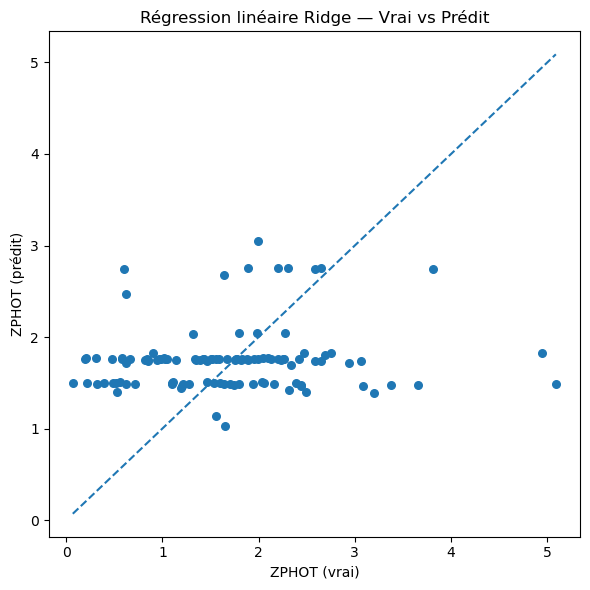

In [188]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rdg, s=30)         # points prédits
mn = float(min(y_test.min(), y_pred_rdg.min()))
mx = float(max(y_test.max(), y_pred_rdg.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")  # diagonale “parfaite”
plt.xlabel(f"{target_col} (vrai)")
plt.ylabel(f"{target_col} (prédit)")
plt.title("Régression linéaire Ridge — Vrai vs Prédit")
plt.tight_layout()
plt.show()

8) Avec le nettoyage des valeurs aberrantes

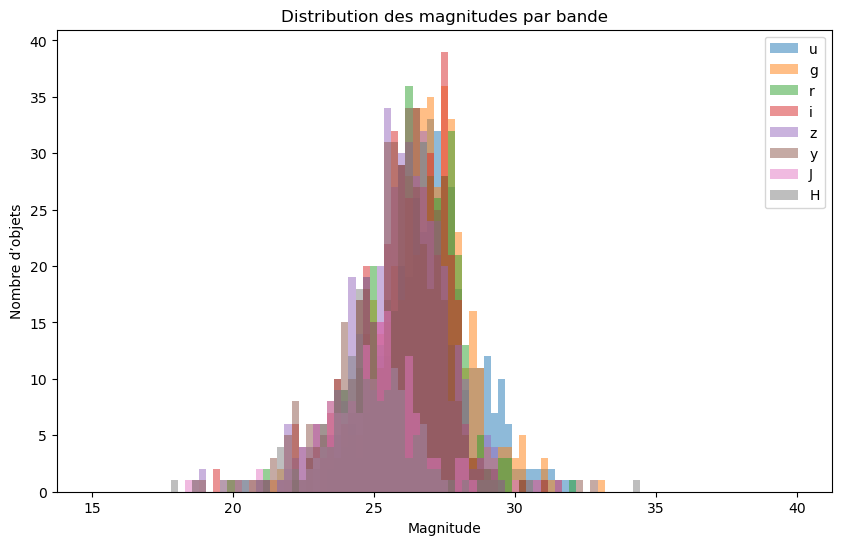

Taille avant filtre: (443, 16)
Taille après suppression des valeurs aberrantes: (282, 16)
Colonnes magnitudes conservées: ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H']
Couleurs créées: ['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'y-J', 'J-H']

Features utilisées: ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'y-J', 'J-H']
Taille finale: (282, 16)



In [189]:
# Remplacement des sentinelles
sentinels = [-99.0, -99.108, -999.0, 99.0]
df = df.replace(sentinels, np.nan)

plt.figure(figsize=(10,6))
for b in mag_cols:
    plt.hist(df[b].dropna(), bins=np.linspace(15, 40, 100), alpha=0.5, label=b)

plt.xlabel("Magnitude")
plt.ylabel("Nombre d’objets")
plt.title("Distribution des magnitudes par bande")
plt.legend()
plt.show()

# Suppression des valeurs aberrantes dans les magnitudes (robuste aux colonnes absentes)
def remove_outliers_iqr(df, cols, k=1.5, min_mag=10, max_mag=35, min_valid_per_col=3):
    # Ne garder que les colonnes effectivement présentes dans df
    cols_present = [c for c in cols if c in df.columns]
    if len(cols_present) < len(cols):
        missing = [c for c in cols if c not in df.columns]
        print(f"Colonnes manquantes ignorées : {missing}")

    mask = pd.Series(True, index=df.index)

    for c in cols_present:
        s = df[c]

        # Si trop peu de valeurs valides, on ignore cette colonne
        if s.notna().sum() < min_valid_per_col:
            print(f"Colonne '{c}' ignorée (pas assez de valeurs valides).")
            continue

        # Bornes physiques plausibles
        phys_ok = s.between(min_mag, max_mag) | s.isna()

        # Bornes IQR
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1

        # Si IQR est nul (toutes valeurs quasi identiques), ignorer
        if pd.isna(iqr) or iqr == 0:
            print(f"Colonne '{c}' ignorée (IQR nul/NaN).")
            mask &= phys_ok
            continue

        lower = q1 - k * iqr
        upper = q3 + k * iqr

        iqr_ok = s.between(lower, upper) | s.isna()
        mask &= (phys_ok & iqr_ok)

    return df[mask]

# Application du filtre 
print(f"Taille avant filtre: {df.shape}")
df = remove_outliers_iqr(df, mag_cols, k=1.5, min_mag=10, max_mag=35)
print(f"Taille après suppression des valeurs aberrantes: {df.shape}")

# Supprimer les bandes TROP manquantes 
min_valid = 5 if len(df) >= 8 else max(3, int(len(df)*0.6))
# S'assurer que les colonnes existent avant de filtrer
mag_cols_present = [c for c in mag_cols if c in df.columns]
keep_mag = [c for c in mag_cols_present if df[c].notna().sum() >= min_valid]

# Garder les bonnes colonnes + la cible
# Assurez-vous que "ZSPEC" est dans df et pas déjà dans keep_mag
all_keep_cols = list(dict.fromkeys(keep_mag + ["ZSPEC"])) # Garde l'ordre, enlève doublons
df = df[all_keep_cols]

print(f"Colonnes magnitudes conservées: {keep_mag}")

# Création des couleurs (ex: g-r, r-i, etc.)
ordered_bands = [b for b in keep_mag] 
color_cols = []
for a, b in zip(ordered_bands, ordered_bands[1:]):
    col_name = f"{a}-{b}"
    df[col_name] = df[a] - df[b]
    color_cols.append(col_name)

print(f"Couleurs créées: {color_cols}")

# Définir les features (magnitudes + couleurs) et la cible
X_cols = keep_mag + color_cols
y_col = "ZSPEC"

# Sélectionner X et y depuis le DataFrame 'df'
X = df[X_cols].values
y = df[y_col].values

# Imputation des NaN restants
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

print("\nFeatures utilisées:", X_cols)
print(f"Taille finale: {df.shape}\n")



In [190]:
# Split 
test_size = 0.25 if len(df) >= 8 else 0.33 if len(df) >= 3 else 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

ols = LinearRegression().fit(X_train_s, y_train)
ridge = Ridge(alpha=1.0, random_state=42).fit(X_train_s, y_train)

# Fonction 'report'
def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>8s} | MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
    return mae, rmse, r2

print("==> Performances sur test :")
y_pred_ols = ols.predict(X_test_s)
y_pred_rdg = ridge.predict(X_test_s)
report("OLS",   y_test, y_pred_ols)
report("Ridge", y_test, y_pred_rdg)

==> Performances sur test :
     OLS | MAE=0.5277 | RMSE=0.6331 | R²=0.3333
   Ridge | MAE=0.5251 | RMSE=0.6315 | R²=0.3365


(0.5251463778373108, np.float64(0.6315199473823855), 0.33650350636581694)

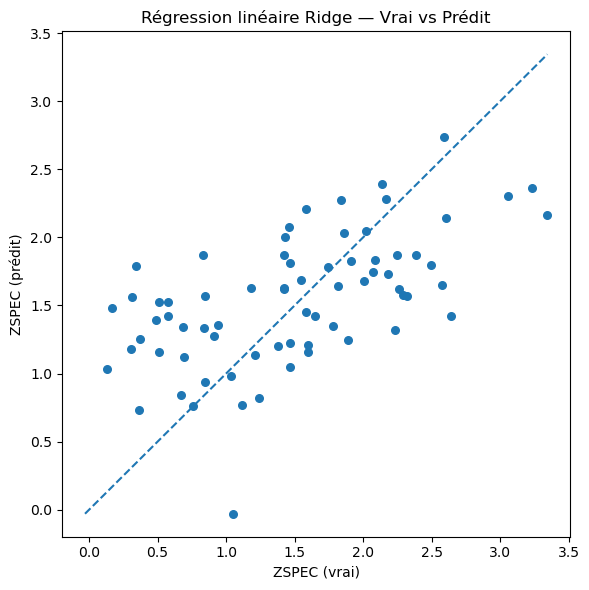

In [191]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rdg, s=30)
mn = float(min(y_test.min(), y_pred_rdg.min()))
mx = float(max(y_test.max(), y_pred_rdg.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
target_col = y_col 
plt.xlabel(f"{target_col} (vrai)")
plt.ylabel(f"{target_col} (prédit)")
plt.title("Régression linéaire Ridge — Vrai vs Prédit")
plt.tight_layout()
plt.show()

9) Interprétation simple

In [192]:
coef_table = pd.DataFrame({
    "feature": X_cols,
    "coef_OLS": ols.coef_,
    "coef_Ridge": ridge.coef_
}).sort_values("coef_Ridge", key=lambda s: s.abs(), ascending=False)
print("\nCoefficients (triés par |coef_Ridge|) :")
print(coef_table.to_string(index=False) + "\n")

print("Taille df après filtres:", len(df))
print("Valides par bande:\n", df[[c for c in df.columns if c in ['u','g','r','i','z','y','J','H']]].notna().sum().sort_values())

print("\nTaille par paire (après dropna):")
bands_all = ["u","g","r","i","z","y","J","H"]
bands = [b for b in bands_all if b in df.columns]
for x, y in itertools.combinations(bands, 2):
    n_pair = df[[x, y]].dropna().shape[0]
    print(f"{x}-{y}: {n_pair}")



Coefficients (triés par |coef_Ridge|) :
feature  coef_OLS  coef_Ridge
    u-g  0.213213    0.212279
    r-i -0.152591   -0.151887
      u  0.150705    0.149967
    z-y  0.106543    0.102393
      H -0.445335   -0.091399
      z  0.076316    0.076633
      i  0.064790    0.065084
    i-z -0.053197   -0.053324
      J  0.401525    0.051467
    y-J -0.043791   -0.047146
      y  0.031880    0.033765
    J-H -0.229895    0.032979
    g-r  0.033426    0.031364
      g  0.030215    0.029999
      r  0.017146    0.017698

Taille df après filtres: 282
Valides par bande:
 J    121
H    121
u    282
g    282
i    282
r    282
y    282
z    282
dtype: int64

Taille par paire (après dropna):
u-g: 282
u-r: 282
u-i: 282
u-z: 282
u-y: 282
u-J: 121
u-H: 121
g-r: 282
g-i: 282
g-z: 282
g-y: 282
g-J: 121
g-H: 121
r-i: 282
r-z: 282
r-y: 282
r-J: 121
r-H: 121
i-z: 282
i-y: 282
i-J: 121
i-H: 121
z-y: 282
z-J: 121
z-H: 121
y-J: 121
y-H: 121
J-H: 121


10) Visualisation des magnitudes

Génération de la grille 10x3 pour 28 paires...


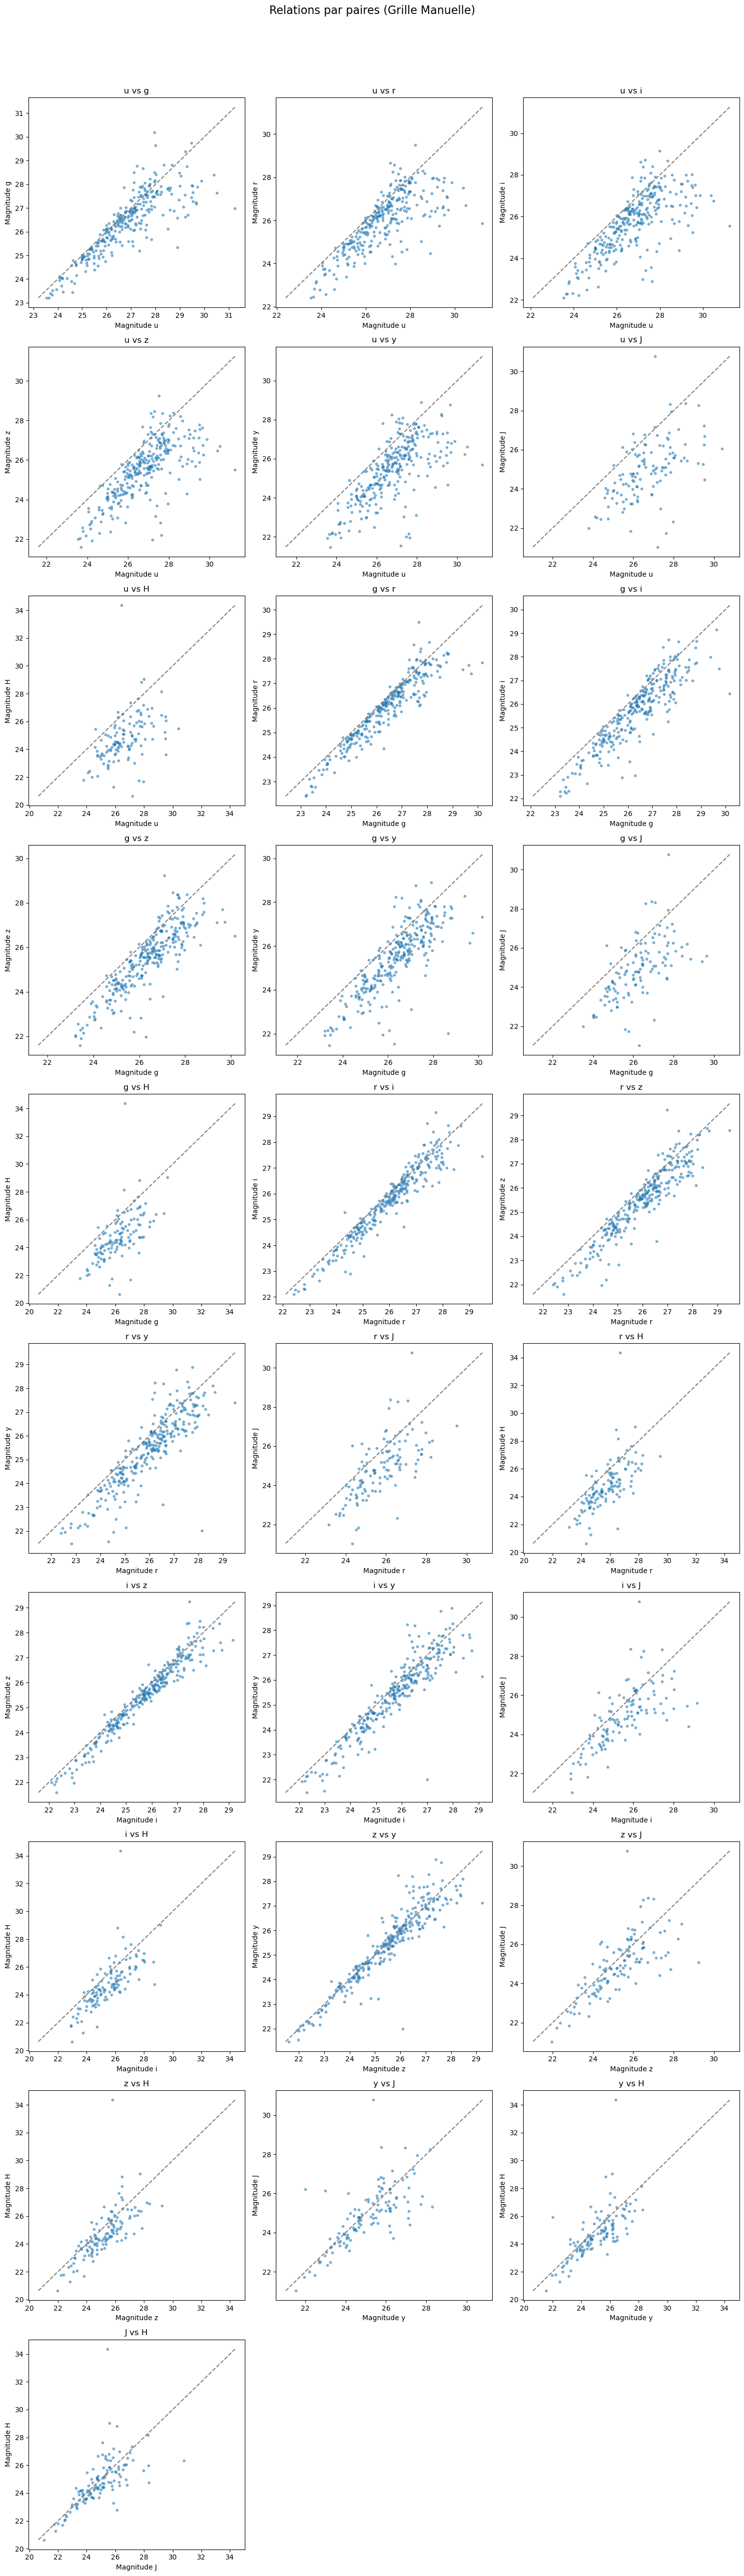

In [193]:
# Toujours basé sur le 'keep_mag' de votre script
plot_cols = [col for col in keep_mag if col != 'ZSPEC']

# Obtenir toutes les paires uniques
pairs = list(itertools.combinations(plot_cols, 2))
n_plots = len(pairs)

if n_plots == 0:
    print("Pas de paires de colonnes à tracer.")
else:
    # Déterminer la taille de la grille (ex: 3 colonnes de large)
    ncols = 3
    # Calculer le nombre de lignes nécessaires
    nrows = int(np.ceil(n_plots / ncols))

    # Créer la grille de sous-graphiques
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
    
    # 'axes' est un tableau 2D, le "mettre à plat" (flat) facilite l'itération
    flat_axes = axes.flat

    print(f"Génération de la grille {nrows}x{ncols} pour {n_plots} paires...")

    # Boucle sur les paires ET les axes en même temps
    for i, (col1, col2) in enumerate(pairs):
        ax = flat_axes[i] # Sélectionne le i-ème sous-graphique
        
        valid_data = df[[col1, col2]].dropna()
        
        if valid_data.empty:
            ax.set_title(f"{col1} vs {col2}\n(Pas de données)")
            ax.set_axis_off()
            continue

        # Tracer sur ce sous-graphique spécifique
        ax.scatter(valid_data[col1], valid_data[col2], s=10, alpha=0.5)
        
        # Calculer les bornes et tracer la ligne diagonale
        mn = float(valid_data.min().min())
        mx = float(valid_data.max().max())
        ax.plot([mn, mx], [mn, mx], linestyle="--", color="gray")
        
        ax.set_xlabel(f"Magnitude {col1}")
        ax.set_ylabel(f"Magnitude {col2}")
        ax.set_title(f"{col1} vs {col2}")

    # Cacher les sous-graphiques vides s'il y en a
    for j in range(i + 1, len(flat_axes)):
        flat_axes[j].set_axis_off()

    plt.tight_layout() # Ajuste automatiquement les graphiques pour éviter les chevauchements
    plt.suptitle("Relations par paires (Grille Manuelle)", y=1.03, fontsize=16)
    plt.show()